Author: Jon Cucci

CS559 - Fundamentals of Machine Learning Final Project

12/16/21

In [1]:
import warnings
warnings.filterwarnings('ignore')
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import pandas as pd
import numpy as np
import os, sys, cv2
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn import metrics
from sklearn.datasets import fetch_openml
np.random.seed(42)
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.keys()

Instructions for updating:
non-resource variables are not supported in the long term


dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

# Additional Functions

In [2]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.figure(figsize=(10,10))
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

In [3]:
def heatmap(cm, data, figsize = (10,10), cmap='binary'):
    plt.figure(figsize=figsize)
    sns.heatmap(cm, annot=True, 
                linewidths=.5, square = True, cmap = cmap);

    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    scores = 'Accuracy Score: {}'.format(data)
    plt.title(scores);

# Preprocessing / EDA

In [4]:
X, y = mnist['data'], mnist['target'].astype(np.uint8)
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [5]:
print(X_train.shape)
print(y_train.shape)

(60000, 784)
(60000,)


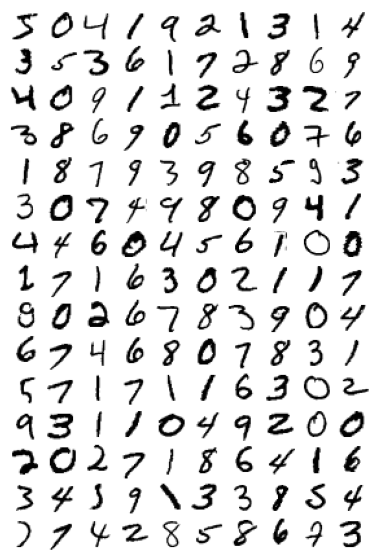

In [6]:
plot_digits(X[:150], images_per_row=10)
plt.show()

# Task 1

### Logistic Regression

In [7]:
from sklearn.linear_model import LogisticRegression
lr_clf = LogisticRegression(random_state=42, verbose=True).fit(X_train, y_train)
lr_clf.score(X_test, y_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.1s finished


0.9255

### Decision Tree

In [8]:
from sklearn.tree import DecisionTreeClassifier
tree_clf = DecisionTreeClassifier(random_state= 42).fit(X_train, y_train)
tree_clf.score(X_test, y_test)

0.8755

### Random Forests

In [9]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state= 42).fit(X_train, y_train)
forest_clf.score(X_test, y_test)

0.9705

### Comparing Accuracies

##### Confusion Matrix Heatmaps

Logistic Regression

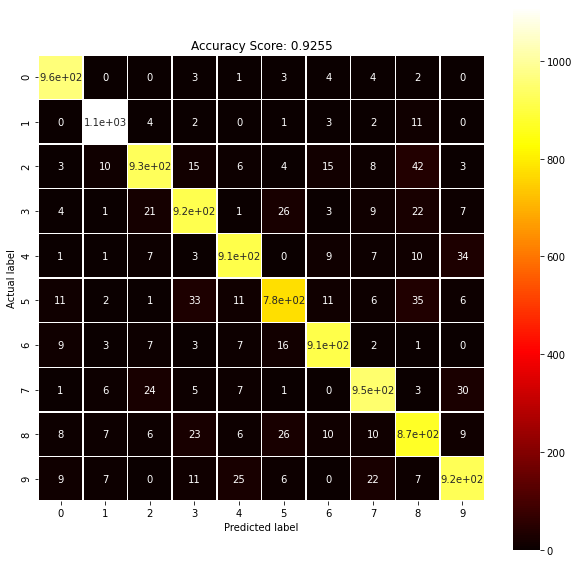

In [10]:
pred = lr_clf.predict(X_test)
cm = metrics.confusion_matrix(y_true=y_test, y_pred = pred, labels = lr_clf.classes_)
train_score, test_score = lr_clf.score(X_train, y_train), lr_clf.score(X_test, y_test)
heatmap(cm, test_score, cmap='hot')

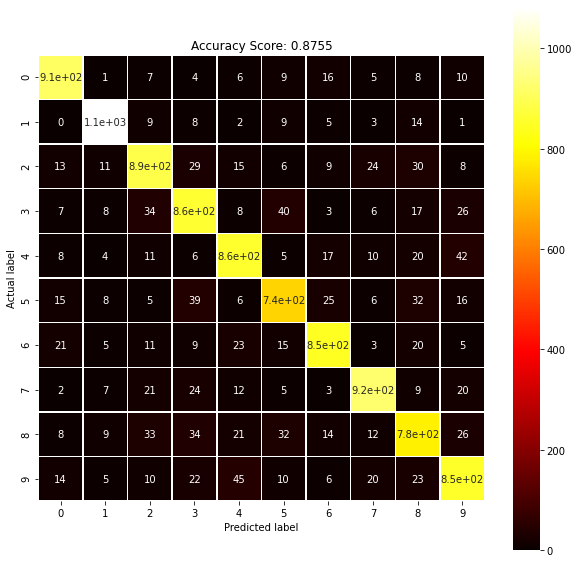

In [11]:
pred = tree_clf.predict(X_test)
cm = metrics.confusion_matrix(y_true=y_test, y_pred = pred, labels = tree_clf.classes_)
train_score, test_score = tree_clf.score(X_train, y_train), tree_clf.score(X_test, y_test)
heatmap(cm, test_score, cmap='hot')

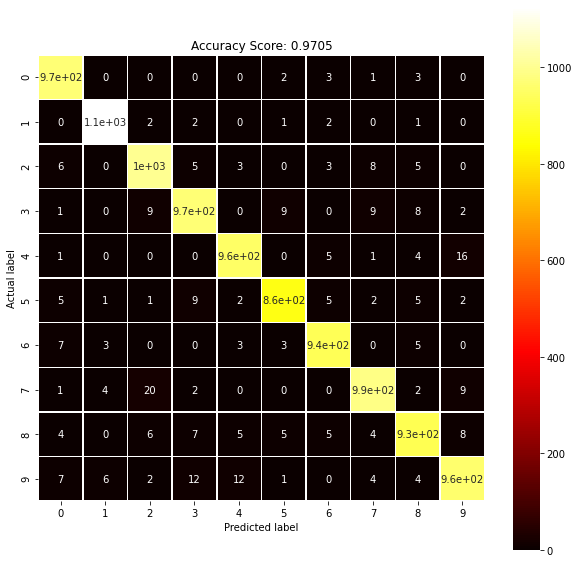

In [12]:
pred = forest_clf.predict(X_test)
cm = metrics.confusion_matrix(y_true=y_test, y_pred = pred, labels = forest_clf.classes_)
train_score, test_score = forest_clf.score(X_train, y_train), forest_clf.score(X_test, y_test)
heatmap(cm, test_score, cmap='hot')

In [13]:
scores = pd.DataFrame([
    ['Linear Regression', lr_clf.score(X_train, y_train), lr_clf.score(X_test, y_test)],
    ['Decision Trees', tree_clf.score(X_train, y_train), tree_clf.score(X_test, y_test)],
    ['Random Forests', forest_clf.score(X_train, y_train), forest_clf.score(X_test, y_test)]],
    columns = ['Classifier', 'Training Score', 'Test Score'])
scores

,Classifier,Training Score,Test Score
0,Linear Regression,0.933917,0.9255
1,Decision Trees,1.000000,0.8755
2,Random Forests,1.000000,0.9705


For my task 1 classifiers, I chose Linear Regression, Decision Trees and Random Forests. For Linear Regression I chose it because I believed the way it trains its model will choose weights for each 784 pixels that will have the lowest drop of accuracy between training and test scores. This is reinforced by the table above, where Linear Regression has a training score of 93.39% and the test score is 92.55%, a minimal drop compared to the rest of the classifiers.

For Decision Tree, I essentially wanted to prove that although it may perfectly classify training data, it is not te best at working on data that it wasn't specifically trained for (i.e. the test data). This one has the biggest change in accuracy, as well as the lowest test score. The training score was 100%, and the test score was 87.55%. Decision trees are usually good when there are a lower amount of classifications for each point of data, but when all 784 pixels are given a value from 0-255 it makes it difficult to read new scenarios, which is why Random Forests exists.

I chose Random Forests for my third and final classifier to prove that it was better at classifying scenarios that it wasn't specifically built or fit from. The way random forests work, means that it takes a bunch of decision trees that don't look at all the data, which makes it a more optimal fit for situations where the data you're classifying isn't exactly the same from the training set. While Decision Tree is massively overfit from training data, random forests is much better. It's training data was 100%, and the test score was 97.05%, the highest of the three for that category.

# Task 2

In [14]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import argparse
import tensorflow_datasets
mnist = tensorflow_datasets.load('mnist')

In [15]:
import math
def get_weights(shape):
    data = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(data)

def get_biases(shape):
    data = tf.constant(0.1, shape=shape)
    return tf.Variable(data)

def create_layer(shape):
    # Get the weights and biases
    W = get_weights(shape)
    b = get_biases([shape[-1]])

    return W, b

def convolution_2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1],
            padding='SAME')

def max_pooling(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
            strides=[1, 2, 2, 1], padding='SAME')

def CNN(X_train, Y_train, X_test, Y_test):
    
    # The images are 28x28. Create the input layer
    x = tf.placeholder(tf.float32, [None, 784])

    # Reshape 'x' into a 4D tensor
    x_image = tf.reshape(x, [-1, 28, 28, 1])

    # Define the first convolutional layer
    w_conv1, b_conv1 = create_layer([5, 5, 1, 32])

    # Convolve the image with weight tensor, add the
    # bias, and then apply the ReLU function
    h_conv1 = tf.nn.relu(convolution_2d(x_image, w_conv1) + b_conv1)

    # Apply the max pooling operator
    h_pool1 = max_pooling(h_conv1)

    # Define the second convolutional layer
    w_conv2, b_conv2 = create_layer([5, 5, 32, 64])

    # Convolve the output of previous layer with the
    # weight tensor, add the bias, and then apply
    # the ReLU function
    h_conv2 = tf.nn.relu(convolution_2d(h_pool1, w_conv2) + b_conv2)

    # Apply the max pooling operator
    h_pool2 = max_pooling(h_conv2)

    # Define the fully connected layer
    w_fc1, b_fc1 = create_layer([3136, 1024])

    # Reshape the output of the previous layer
    h_pool2_flat = tf.reshape(h_pool2, [-1, 3136])

    # Multiply the output of previous layer by the
    # weight tensor, add the bias, and then apply
    # the ReLU function * Use "tf.matmul" for matrix multiplication
    h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, w_fc1) + b_fc1)
    
    # Define the dropout layer using a probability placeholder
    # for all the neurons
    keep_prob = tf.placeholder(tf.float32)
    h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)
    
    # Define the readout layer (output layer)
    w_fc2, b_fc2 = create_layer([1024, 10])
    y_conv = tf.matmul(h_fc1_drop, w_fc2) + b_fc2

    # Define the entropy loss and the optimizer
    y_loss = tf.placeholder(tf.float32, [None, 10])
    #y_loss = tf.keras.utils.to_categorical(y_loss, num_classes=10, dtype="float32")
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_conv, labels=y_loss))
    optimizer = tf.train.AdamOptimizer(1e-4).minimize(loss)

    # Define the accuracy computation
    predicted = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_loss, 1))
    accuracy = tf.reduce_mean(tf.cast(predicted, tf.float32))

    # Create and run a session
    sess = tf.InteractiveSession()
    init = tf.initialize_all_variables()
    sess.run(init)

    # Start training
    batch_size = 75
    num_iterations = math.ceil(X_train.shape[0] / batch_size)
    start = 0
    end = batch_size
    print('\nTraining the model....')
    for i in range(num_iterations):

        batch = (X_train[start:end], Y_train[start:end])
        start = end
        end = min(end + batch_size, X_train.shape[0])
        
        # Print progress
        if i % 50 == 0:
            cur_accuracy = accuracy.eval(feed_dict = {
                    x: batch[0], y_loss: tf.keras.utils.to_categorical(batch[1], num_classes=10), keep_prob: 1.0})
            print('Iteration', i, ', Accuracy =', cur_accuracy)

        # Train on the current batch
        optimizer.run(feed_dict = {x: batch[0], y_loss: tf.keras.utils.to_categorical(batch[1], num_classes=10), keep_prob: 0.5})

    # Compute accuracy using test data
    test_accuracy = accuracy.eval(feed_dict = {
            x: X_test, y_loss: tf.keras.utils.to_categorical(Y_test, num_classes=10),
            keep_prob: 1.0})
    print('Test accuracy =', test_accuracy)
    
    return cur_accuracy, test_accuracy

In [16]:
cnn = CNN(X_train, y_train, X_test, y_test)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



Instructions for updating:
Use `tf.global_variables_initializer` instead.


Instructions for updating:
Use `tf.global_variables_initializer` instead.



Training the model....
Iteration 0 , Accuracy = 0.10666667
Iteration 50 , Accuracy = 0.74666667
Iteration 100 , Accuracy = 0.85333335
Iteration 150 , Accuracy = 0.8933333
Iteration 200 , Accuracy = 0.9066667
Iteration 250 , Accuracy = 0.94666666
Iteration 300 , Accuracy = 0.81333333
Iteration 350 , Accuracy = 0.92
Iteration 400 , Accuracy = 0.93333334
Iteration 450 , Accuracy = 0.92
Iteration 500 , Accuracy = 0.9066667
Iteration 550 , Accuracy = 0.9066667
Iteration 600 , Accuracy = 0.93333334
Iteration 650 , Accuracy = 0.94666666
Iteration 700 , Accuracy = 0.9866667
Iteration 750 , Accuracy = 0.96
Test accuracy = 0.9556


# Task 3

###### Importing and renaming files so I don't have to do it manally.

In [17]:
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
X, y = mnist['data'], mnist['target'].astype(np.uint8)
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]
'''
number, iteration = 0,1
for file in os.listdir(os.curdir + "/my_images"):
    os.rename(os.curdir + "/my_images/" + file,os.curdir + "/my_images/{}_{}.png".format(number, iteration))
    iteration+=1
    if iteration == 6:
        number+=1
        iteration=1
'''

'\nnumber, iteration = 0,1\nfor file in os.listdir(os.curdir + "/my_images"):\n    os.rename(os.curdir + "/my_images/" + file,os.curdir + "/my_images/{}_{}.png".format(number, iteration))\n    iteration+=1\n    if iteration == 6:\n        number+=1\n        iteration=1\n'

array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4,
       4, 4, 4, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 8, 8, 8, 8,
       8, 9, 9, 9, 9, 9])

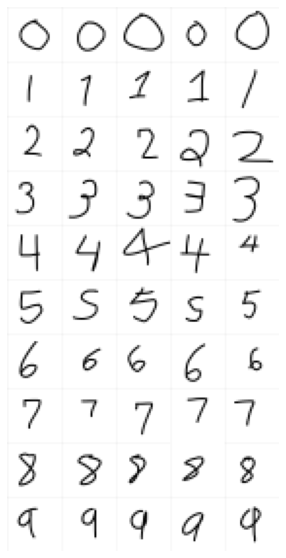

In [18]:
root = os.curdir+"/my_images/"
def read_img(img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (28,28), interpolation = cv2.INTER_AREA)
    x_img = np.array([0]*784)
    
    for i in range(28):
        for j in range(28):
            idx = i*28+j
            x_img[idx] = 255 - img[i][j][0]
    return x_img, img

X_mydig, y_mydig, imgs = [],[],[]

for subdir, dirs, files in os.walk(root):
    for file in files:
        if file.endswith('.png'):
            path = os.path.join(subdir, file)
            digit, img = read_img(path)
            label = int(os.path.splitext(file)[0][0])
            X_mydig.append(digit)
            y_mydig.append(label)
            imgs.append(img)
            
X_mydig = np.array(X_mydig)
y_mydig = np.array(y_mydig)

plot_digits(X_mydig, images_per_row = 5)
y_mydig

### Models from task 1 and 2

###### Linear Regression

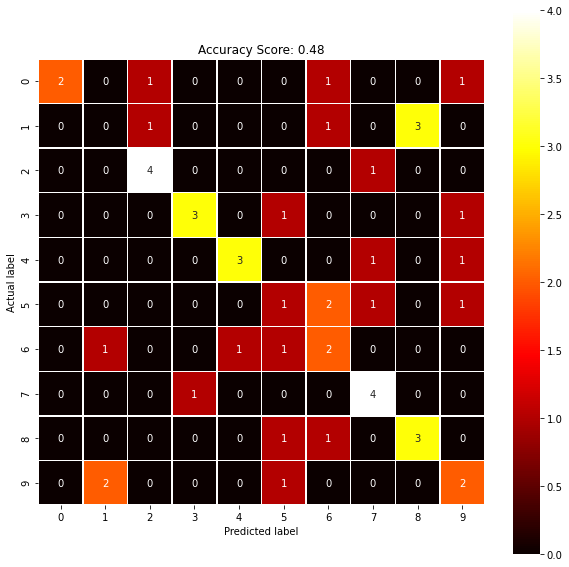

In [19]:
pred = lr_clf.predict(X_mydig)
cm = metrics.confusion_matrix(y_true=y_mydig, y_pred = pred, labels = lr_clf.classes_)
train_score, test_score = lr_clf.score(X_train, y_train), lr_clf.score(X_mydig, y_mydig)
heatmap(cm, test_score, cmap='hot')

##### Decision Tree

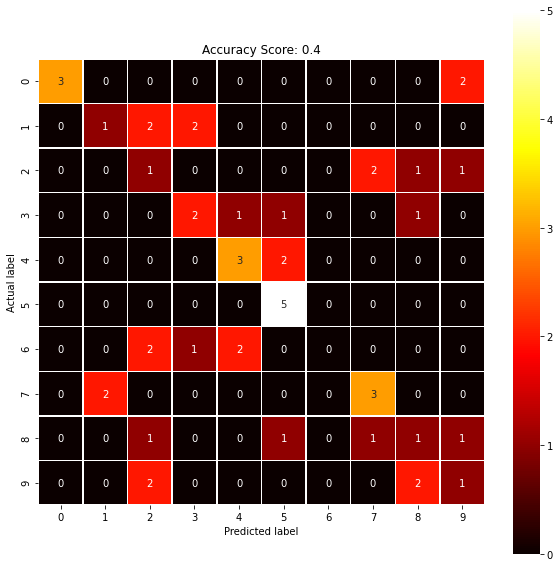

In [20]:
pred = tree_clf.predict(X_mydig)
cm = metrics.confusion_matrix(y_true=y_mydig, y_pred = pred, labels = tree_clf.classes_)
train_score, test_score = tree_clf.score(X_train, y_train), tree_clf.score(X_mydig, y_mydig)
heatmap(cm, test_score, cmap='hot')

##### Random Forest

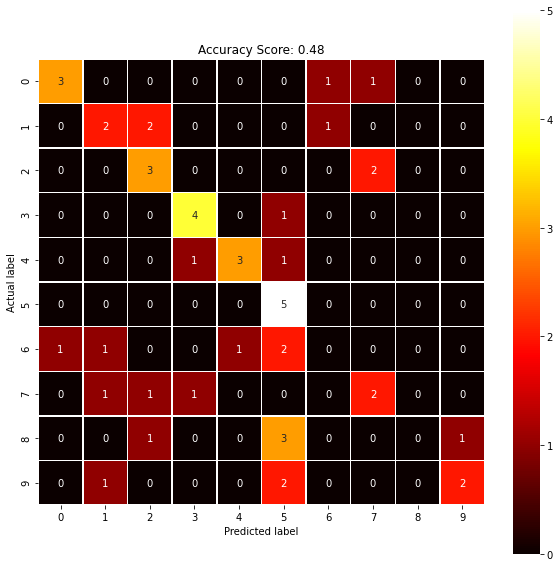

In [21]:
pred = forest_clf.predict(X_mydig)
cm = metrics.confusion_matrix(y_true=y_mydig, y_pred = pred, labels = forest_clf.classes_)
train_score, test_score = forest_clf.score(X_train, y_train), forest_clf.score(X_mydig, y_mydig)
heatmap(cm, test_score, cmap='hot')

In [22]:
cnn_my_dig = CNN(X_train, y_train, X_mydig, y_mydig)


Training the model....
Iteration 0 , Accuracy = 0.08
Iteration 50 , Accuracy = 0.7733333
Iteration 100 , Accuracy = 0.88
Iteration 150 , Accuracy = 0.88
Iteration 200 , Accuracy = 0.92
Iteration 250 , Accuracy = 0.94666666
Iteration 300 , Accuracy = 0.85333335
Iteration 350 , Accuracy = 0.94666666
Iteration 400 , Accuracy = 0.88
Iteration 450 , Accuracy = 0.94666666
Iteration 500 , Accuracy = 0.96
Iteration 550 , Accuracy = 0.8933333
Iteration 600 , Accuracy = 0.88
Iteration 650 , Accuracy = 0.94666666
Iteration 700 , Accuracy = 0.97333336
Iteration 750 , Accuracy = 0.94666666
Test accuracy = 0.52


In [23]:
scores = pd.DataFrame([
    ['Linear Regression', lr_clf.score(X_train, y_train), lr_clf.score(X_mydig, y_mydig)],
    ['Decision Trees', tree_clf.score(X_train, y_train), tree_clf.score(X_mydig, y_mydig)],
    ['Random Forests', forest_clf.score(X_train, y_train), forest_clf.score(X_mydig, y_mydig)],
    ['CNN', cnn_my_dig[0], cnn_my_dig[1]]],
    columns = ['Classifier', 'Training Score', 'My Digits Score'])
scores

,Classifier,Training Score,My Digits Score
0,Linear Regression,0.933917,0.48
1,Decision Trees,1.000000,0.40
2,Random Forests,1.000000,0.48
3,CNN,0.946667,0.52


Our convolutional Neural Network has the highest score accuracy in this run, 52%.